In [3]:
import pandas as pd

df = pd.read_csv('features_3_sec.csv')
X = df.drop(['filename', 'label'], axis=1)
y = df['label']

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cols = [col for col in X.columns]
X = X.loc[:,cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=1)

In [7]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

def model_evaluation(model, X_train, X_test, desc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(desc)
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))
    return y_pred


In [41]:
model = RandomForestClassifier()
model_evaluation(model, X_train, X_test, 'RFC Evaluation')

model = SVC()
model_evaluation(model, X_train, X_test, 'SVC Evaluation')

model = DecisionTreeClassifier()
model_evaluation(model, X_train, X_test, 'DCT Evaluation')

model = SGDClassifier()
model_evaluation(model, X_train, X_test, 'SGD Evaluation')

model = GaussianNB()
model_evaluation(model, X_train, X_test,'NB Evaluation')

model = KNeighborsClassifier()
model_evaluation(model, X_train, X_test,'KNN Evaluation')

model = XGBClassifier(objective="reg:squaredlogerror", eval_metric="mlogloss")
y_pred = model_evaluation(model, X_train, X_test, 'XGB Evaluation')

RFC Evaluation
              precision    recall  f1-score   support

       blues       0.81      0.88      0.85       200
   classical       0.89      0.97      0.93       199
     country       0.81      0.80      0.81       199
       disco       0.86      0.86      0.86       200
      hiphop       0.92      0.84      0.88       200
        jazz       0.81      0.85      0.83       200
       metal       0.90      0.94      0.92       200
         pop       0.89      0.89      0.89       200
      reggae       0.84      0.83      0.84       200
        rock       0.85      0.69      0.76       200

    accuracy                           0.86      1998
   macro avg       0.86      0.86      0.86      1998
weighted avg       0.86      0.86      0.86      1998

SVC Evaluation
              precision    recall  f1-score   support

       blues       0.12      0.01      0.01       200
   classical       0.49      0.79      0.61       199
     country       0.19      0.29      0.23     

In [24]:
import numpy as np

n_feature = 10
feature_importance = pd.Series(model.feature_importances_, index=np.arange(X_train.shape[1]))
top_feature = feature_importance.sort_values(ascending=False).head(n_feature).index.tolist()
important_feature = [X.columns[i] for i in top_feature]
print(f'{n_feature} important feature: {", ".join(important_feature)}')

10 important feature: perceptr_var, spectral_bandwidth_mean, chroma_stft_var, mfcc1_var, chroma_stft_mean, rms_var, mfcc4_mean, rolloff_var, rms_mean, perceptr_mean


In [50]:
from sklearn.model_selection import GridSearchCV 

param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [4, 5, 6],
    'n_estimators': [1000]
        }

In [51]:
import time

model = XGBClassifier(objective="reg:squaredlogerror", eval_metric="mlogloss")
start_time = time.time() 
grid = GridSearchCV(model, param_grid, cv=4)
grid.fit(X_train, y_train)
end_time = time.time() 
execution_time = end_time - start_time 
print("Время на поиск гиперпараметров:", execution_time)
print(grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0.0))


Время на поиск гиперпараметров: 957.3684813976288
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1000}
              precision    recall  f1-score   support

       blues       0.90      0.92      0.91       200
   classical       0.93      0.97      0.95       199
     country       0.86      0.88      0.87       199
       disco       0.90      0.93      0.91       200
      hiphop       0.93      0.87      0.90       200
        jazz       0.86      0.92      0.89       200
       metal       0.95      0.95      0.95       200
         pop       0.93      0.90      0.91       200
      reggae       0.91      0.91      0.91       200
        rock       0.88      0.82      0.85       200

    accuracy                           0.90      1998
   macro avg       0.91      0.90      0.90      1998
weighted avg       0.91      0.90      0.90      1998



Время на обучение и предсказание при заданных гиперпараметрах: 34.973503828048706


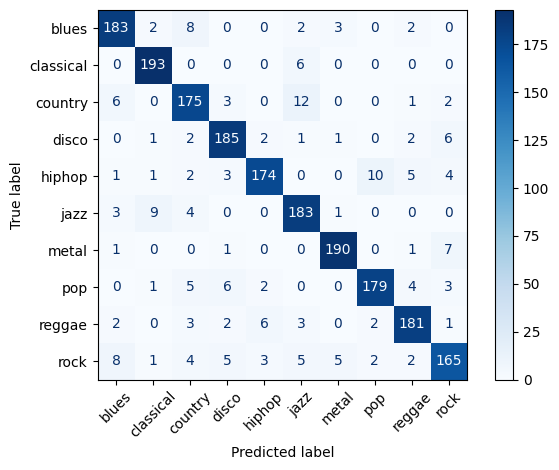

In [53]:
import time

start_time = time.time() 
model = XGBClassifier(objective="reg:squaredlogerror", eval_metric="mlogloss", learning_rate=0.2, max_depth=5, n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
end_time = time.time() 
execution_time = end_time - start_time 
print("Время на обучение и предсказание при заданных гиперпараметрах:", execution_time)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.tight_layout()
plt.show()

import pickle

file_name="network.pkl"
pickle.dump(model, open(file_name, "wb"))